In [ ]:
%matplotlib inline


# Compute MNE inverse solution on evoked data in a mixed source space


Create a mixed source space and compute MNE inverse solution on evoked dataset.



In [10]:
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
import mne

from mne.datasets import sample
from mne import setup_source_space, setup_volume_source_space
from mne import make_forward_solution
from mne.minimum_norm import make_inverse_operator, apply_inverse
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img


# Set dir
data_path = sample.data_path()
subject = 'sample'
data_dir = op.join(data_path, 'MEG', subject)
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

# Set file names
fname_mixed_src = op.join(bem_dir, '%s-oct-6-mixed-src.fif' % subject)
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz')

fname_model = op.join(bem_dir, '%s-5120-bem.fif' % subject)
fname_bem = op.join(bem_dir, '%s-5120-bem-sol.fif' % subject)

fname_evoked = data_dir + '/sample_audvis-ave.fif'
fname_trans = data_dir + '/sample_audvis_raw-trans.fif'
fname_fwd = data_dir + '/sample_audvis-meg-oct-6-mixed-fwd.fif'
fname_cov = data_dir + '/sample_audvis-shrunk-cov.fif'

Set up our source space.



In [11]:
# Get a surface-based source space. 
surf = setup_source_space(subject, spacing='ico5', add_dist=False, subjects_dir=subjects_dir)
# Get a volume-based source space. 
labels_vol = ['Left-Hippocampus', 'Right-Hippocampus']  
hippocampus= setup_volume_source_space(subject, mri=fname_aseg, pos=3.0, bem=fname_model,
    volume_label=labels_vol, mindist=3.0, subjects_dir=subjects_dir, verbose=True)

# Generate the mixed source space
src = surf+hippocampus
n = sum(src[i]['nuse'] for i in range(len(src)))
print('the src space contains %d spaces and %d points' % (len(src), n))



Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\PP255359\mne_data\MNE-sample-data\subjects
Subject      = sample
Surface      = white
Icosahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\lh.white...
Mapping lh sample -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\lh.sphere...
    Triangle neighbors and vertex normals...
Setting up the triangulation for the decimated surface...
loaded lh.white 10242/155407 selected to source space (ico = 5)

Loading C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\rh.white...
Mapping rh sample -> ico (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\surf\rh.sphere...
    Triangle neighbors and ver

Export source positions to nift file:



In [12]:
# Compute the fwd matrix
fwd = make_forward_solution(fname_evoked, fname_trans, src, fname_bem,
                            mindist=5.0,  
                            meg=True, eeg=False, n_jobs=1)

leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

src_fwd = fwd['src']
n = sum(src_fwd[i]['nuse'] for i in range(len(src_fwd)))
print('the fwd src space contains %d spaces and %d points' % (len(src_fwd), n))

# Load data
condition = 'Left Auditory'
evoked = mne.read_evokeds(fname_evoked, condition=condition,
                          baseline=(None, 0))
noise_cov = mne.read_cov(fname_cov)

# Compute inverse solution and for each epoch
snr = 3.0           # use smaller SNR for raw data
inv_method = 'MNE'  # sLORETA, MNE, dSPM
lambda2 = 1.0 / snr ** 2

# Compute inverse operator
inverse_operator = make_inverse_operator(evoked.info, fwd, noise_cov,
                                         loose=1.0, depth=0.8, fixed=False)

stcs = apply_inverse(evoked, inverse_operator, lambda2, inv_method,
                     pick_ori=None)



Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=10242, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=10242, coordinate_frame=MRI (surface RAS)>, <volume (Left-Hippocampus), n_used=146, coordinate_frame=MRI (surface RAS)>, <volume (Right-Hippocampus), n_used=151, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform : C:\Users\PP255359\mne_data\MNE-sample-data\MEG\sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis-ave.fif
Conductor model   : C:\Users\PP255359\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 4 source spaces a total of 20781 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  0.812405  0.582954       6.86 mm
     0.034894 -0.583008  0.811716      28.88 mm
     0.000000  0.000000  

In [4]:
#tt=mne.MixedSourceEstimate(stcs.data, vertices=stcs.vertices, tmin=stcs.tmin, tstep=stcs.tstep, subject=subject, verbose=None)
#tt.save('mixedstc.stc',ftype='stc',verbose=None)


NameError: name 'save_mixed_stc' is not defined

In [13]:
# Export result as a 4D nifti object
img = stcs.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, 'mne_%s_inverse.nii.gz' % method)

t1_fname = data_path + '/subjects/sample/mri/T1.mgz'

# Plotting with nilearn 
plot_stat_map(index_img(img, 61), t1_fname, threshold=8.,
              title='%s (t=%.1f s.)' % (method, stc.times[61]))
plt.show()

AttributeError: 'MixedSourceEstimate' object has no attribute 'as_volume'

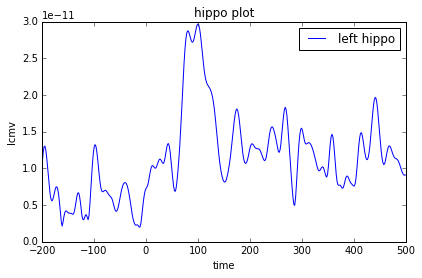

In [20]:

n_sources = 0
data_per_src= []
for s in fwd['src']:
    n_sources_in_s = s['inuse'].sum()
    this_data = stcs.data[n_sources:n_sources + n_sources_in_s, :]
    n_sources += n_sources_in_s
    data_per_src.append(this_data)
hippo_lh = data_per_src[-2] #left hippocampus
left_hippo=np.mean(hippo_lh, axis=0)
hippo_rh= data_per_src[-1] #right hippocampus
right_hippo=np.mean(hippo_rh, axis=0)

            
src = fwd['src']
fig,axes=plt.subplots(1)
axes.plot(1e3*stcs.times, left_hippo, label='left hippo')
#axes.plot(1e3*stcs.times, right_hippo, 'k', label='right hippo')
axes.set(xlabel='time', ylabel='lcmv', title='hippo plot')

axes.legend()
mne.viz.tight_layout()
plt.show()